In [1]:
import time
import datetime
import copy
import numpy as np
import math

import pandas as pd
import json
from bson.json_util import dumps

In [2]:
from fastparquet import ParquetFile,write

In [91]:
udf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40703 entries, 11049447 to 9968570
Data columns (total 24 columns):
category                 40703 non-null int64
past                     40703 non-null int32
votes                    40703 non-null int64
is_eventbrite            40703 non-null int32
is_free                  40703 non-null int32
doors                    40703 non-null int32
sold_out                 40703 non-null int32
venue.id                 40703 non-null int64
venue.popularity         40703 non-null float64
venue.zip                40703 non-null int64
ticket_allages           40703 non-null int32
ticket_price_low         40703 non-null float64
ticket_price_max         40703 non-null float64
min_age                  40703 non-null int32
artist.popularity.sum    40703 non-null float64
artist.popularity.avg    40703 non-null float64
artist.popularity.max    40703 non-null float64
dow                      40703 non-null int64
doy                      40703 non-null in

In [122]:
udf.head()

,category,past,votes,is_eventbrite,is_free,doors,sold_out,venue.id,venue.popularity,venue.zip,...,artist.popularity.sum,artist.popularity.avg,artist.popularity.max,dow,doy,month,day,hour,venue.tol_num_events,ev_id
id,,,,,,,,,,,,,,,,,,,,,
11049447,0,0,784,0,0,1,0,113,15.0,78701,...,73238.0,73238.0,73238.0,3,276,10,3,19,377,11049447
11049456,0,0,223,0,0,1,0,175439,15.0,78741,...,101.0,101.0,101.0,3,276,10,3,20,116,11049456
11049430,0,0,163,0,0,1,0,654,15.0,78702,...,3770.0,1885.0,1885.0,3,276,10,3,18,237,11049430
11186444,1,0,151,0,1,0,0,407459,1.0,0,...,28.0,28.0,28.0,3,276,10,3,20,31,11186444
11141496,1,0,126,1,0,1,0,302617,1.0,78701,...,0.0,0.0,0.0,3,276,10,3,19,244,11141496


In [60]:
pf=ParquetFile('full_1st_setoffeat_events4ml.parq')
udf=pf.to_pandas()

In [61]:
# put back event id , used for drop duplicates
evvts=pd.read_csv('event_votes.csv')

In [62]:
udf['ev_id']=evvts['id'].values

In [63]:
udf.drop_duplicates(subset='ev_id',inplace=True)

In [123]:
write('full_1st_setoffeat_events4ml2.parq',udf)

In [68]:
udf_y=udf['votes'] # data y--target
##*****transform the votes to log(x-np.mean(x)+1) ******###
udf_y=[np.log(x+1) for x in udf_y]
a=list(udf.columns.values)
a.remove('votes')
a.remove('ev_id') 
udf_x=udf[a]       # data X

In [117]:
org=udf['votes'][0:10]
converted=udf_y[0:10]

In [118]:
back=[np.exp(x)-1 for x in converted]

In [121]:
## start Modeling trail
## bechmark model metric setup
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(udf_x, udf_y, test_size=0.3, random_state=12)

In [73]:
X_train.head()

,category,past,is_eventbrite,is_free,doors,sold_out,venue.id,venue.popularity,venue.zip,ticket_allages,...,min_age,artist.popularity.sum,artist.popularity.avg,artist.popularity.max,dow,doy,month,day,hour,venue.tol_num_events
id,,,,,,,,,,,,,,,,,,,,,
9958261,4,1,0,1,0,0,400317,1.0,78724,0,...,0,0.0,0.0,0.0,4,278,10,5,18,63
10153657,4,1,0,0,0,0,268172,1.0,0,0,...,0,0.0,0.0,0.0,5,342,12,8,22,561
10008973,0,1,0,1,1,0,119,7.0,78701,0,...,21,1.0,1.0,1.0,1,331,11,27,21,460
10683150,7,1,0,0,0,0,397700,1.0,0,0,...,0,0.0,0.0,0.0,5,131,5,11,14,1
9930547,1,1,0,1,0,0,19704,15.0,78701,0,...,0,220.0,55.0,55.0,4,285,10,12,20,481


In [104]:
# convert votes back to original values for comparison
b_y=np.log(np.mean(udf['votes'])+1)

In [105]:
b_y

2.7186223279297987

In [142]:
print("predicted benchmark value is:",np.exp(b_y)-1)

predicted benchmark value is: 14.15942313834361


In [106]:
# convert y_train back to original
y_org_train=[np.exp(x)-1 for x in y_train]

In [108]:
b_pred_y = [b_y for x in range(len(y_train)) ]

In [109]:
# access the benchmark y_pred
from sklearn import metrics
print('MSE score(training):',metrics.mean_squared_error(y_org_train, b_pred_y))
print('MAE score(training):',metrics.mean_absolute_error(y_org_train, b_pred_y))
#print('MSE score:',metrics.mean_squared_error(y_test, pred_test))
#print('MAE score:',metrics.mean_absolute_error(y_test, pred_test))

MSE score(training): 10744.594427259293
MAE score(training): 13.245873549386873


In [110]:
## linear regression model
from sklearn import linear_model
LR_model0 = linear_model.LinearRegression()

In [111]:
LR_model0.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [112]:
pred_train = LR_model0.predict(X_train)
print('training score of Linear Regression:',LR_model0.score(X_train,pred_train))
pred_test=LR_model0.predict(X_test)
print('testing score of Linear Regression:',LR_model0.score(X_test,pred_test))

training score of Linear Regression: 1.0
testing score of Linear Regression: 1.0


In [113]:
print('MSE score(training):',metrics.mean_squared_error(y_train, pred_train))
print('MAE score(training):',metrics.mean_absolute_error(y_train, pred_train))
print('MSE score:',metrics.mean_squared_error(y_test, pred_test))
print('MAE score:',metrics.mean_absolute_error(y_test, pred_test))

MSE score(training): 0.9396493791019523
MAE score(training): 0.6935414216923182
MSE score: 0.9489215433161305
MAE score: 0.6961246517962636


In [164]:
from scipy import stats
import statsmodels.api as sm

In [165]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     713.8
Date:                Tue, 29 Oct 2019   Prob (F-statistic):               0.00
Time:                        17:06:56   Log-Likelihood:                -39542.
No. Observations:               28492   AIC:                         7.913e+04
Df Residuals:                   28470   BIC:                         7.931e+04
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.47

C:\Users\z0043H7B\AppData\Local\Continuum\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [116]:
## find the true prediction error on non-log data
pred_org_train=[np.exp(x)-1 for x in pred_train]
pred_org_test=[np.exp(x)-1 for x in pred_test]
y_org_test=[np.exp(x)-1 for x in y_test]
print('MSE score(training):',metrics.mean_squared_error(y_org_train, pred_org_train))
print('MAE score(training):',metrics.mean_absolute_error(y_org_train, pred_org_train))
print('MSE score:',metrics.mean_squared_error(y_org_test, pred_org_test))
print('MAE score:',metrics.mean_absolute_error(y_org_test, pred_org_test))

MSE score(training): 586743.5130441936
MAE score(training): 18.078332659346724
MSE score: 858435.9916427701
MAE score: 21.36375288430101


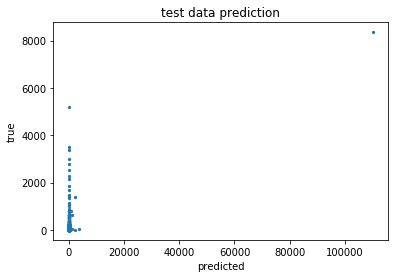

In [125]:
# plot prediction result:
import matplotlib.pyplot as plt
plt.scatter(pred_org_test,y_org_test, s=5)
plt.title('test data prediction')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

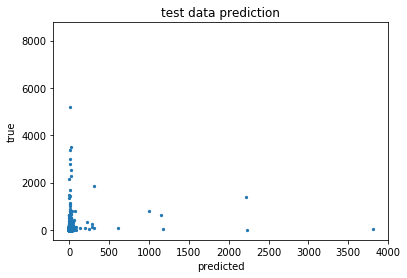

In [128]:
# plot prediction result:
import matplotlib.pyplot as plt
plt.scatter(pred_org_test,y_org_test, s=5)
plt.title('test data prediction')
plt.xlabel('predicted')
plt.ylabel('true')
plt.xlim([-200,4000])
plt.show()

In [132]:
## save a defaultdict for the coef of each attribute:
weights=zip(list(udf_x.columns),LR_model0.coef_) # use a iterable to print the coefficient and their corresponding column name
m0_coef=dict(zip(udf_x.columns, LR_model0.coef_))

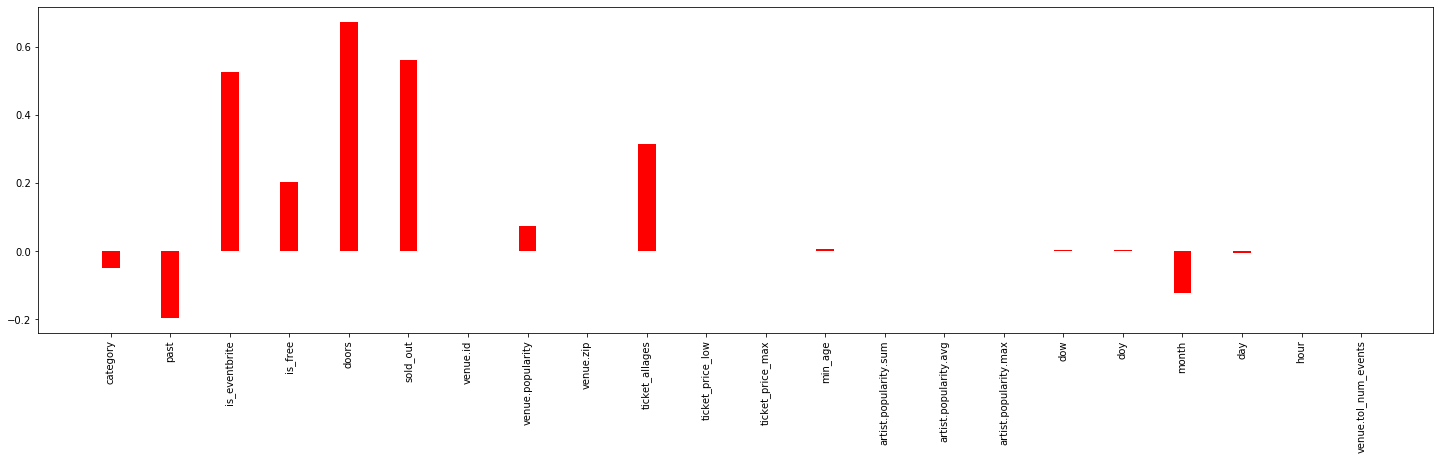

In [133]:
# plot a histogram chart to illustrate :

x_tick_label=list(udf_x.columns)
hist_val=LR_model0.coef_
fig, ax = plt.subplots(figsize=(25,6))
index=np.arange(len(LR_model0.coef_))
ax.bar(index,hist_val, .3, color='r')
ax.set_xticks(range(0, 22, 1))
ax.set_xticklabels(x_tick_label, rotation='vertical')
plt.show()


In [134]:
# try random forest model to access better interpretation to features
from sklearn.ensemble import RandomForestRegressor
RF_model0 = RandomForestRegressor(random_state=12,verbose=10)

In [135]:
RF_model0.fit(X_train,y_train)

C:\Users\z0043H7B\AppData\Local\Continuum\miniconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


building tree 1 of 10
building tree 2 of 10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.4s remaining:    0.0s


building tree 3 of 10
building tree 4 of 10


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.7s remaining:    0.0s


building tree 5 of 10
building tree 6 of 10


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    1.0s remaining:    0.0s


building tree 7 of 10
building tree 8 of 10


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    1.3s remaining:    0.0s


building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s finished


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=12, verbose=10,
                      warm_start=False)

In [139]:
pred_train_RF = RF_model0.predict(X_train)
print('training score of RandomForest:',RF_model0.score(X_train,pred_train_RF))
pred_test_RF = RF_model0.predict(X_test)
print('test score of RandomForest:',RF_model0.score(X_test,pred_test_RF))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elap

training score of RandomForest: 1.0
test score of RandomForest: 1.0


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elap

In [140]:
# access several benchmark RMSE for reference:
print('MSE score(training):',metrics.mean_squared_error(y_train, pred_train_RF))
print('MAE score(training):',metrics.mean_absolute_error(y_train, pred_train_RF))
print('MSE score:',metrics.mean_squared_error(y_test, pred_test_RF))
print('MAE score:',metrics.mean_absolute_error(y_test, pred_test_RF))

MSE score(training): 0.09193189807270227
MAE score(training): 0.17974207525944336
MSE score: 0.5138327700675699
MAE score: 0.45074805630719006


In [141]:
# access original error metrics
pred_org_train_RF=[np.exp(x)-1 for x in pred_train_RF]
pred_org_test_RF=[np.exp(x)-1 for x in pred_test_RF]
print('MSE score(training):',metrics.mean_squared_error(y_org_train, pred_org_train_RF))
print('MAE score(training):',metrics.mean_absolute_error(y_org_train, pred_org_train_RF))
print('MSE score:',metrics.mean_squared_error(y_org_test, pred_org_test_RF))
print('MAE score:',metrics.mean_absolute_error(y_org_test, pred_org_test_RF))

MSE score(training): 5953.98394927712
MAE score(training): 5.71081423584717
MSE score: 13271.975068824599
MAE score: 11.035839828750735


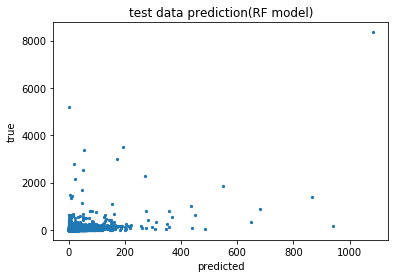

In [143]:
# plot prediction result:
plt.scatter(pred_org_test_RF,y_org_test, s=5)
plt.title('test data prediction(RF model)')
plt.xlabel('predicted')
plt.ylabel('true')
plt.show()

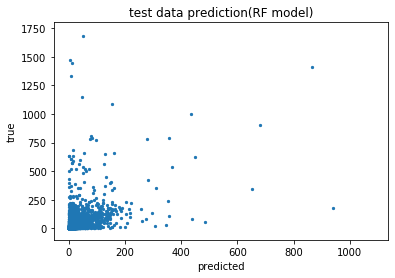

In [144]:
# plot prediction result:
plt.scatter(pred_org_test_RF,y_org_test, s=5)
plt.title('test data prediction(RF model)')
plt.xlabel('predicted')
plt.ylabel('true')
plt.ylim([-100,1800])
plt.show()

category 0.059192348991623046
past 0.0005190593415728053
is_eventbrite 0.006696026715254525
is_free 0.01223116513683886
doors 0.022365059073688343
sold_out 0.0008528636488333005
venue.id 0.0764968934904855
venue.popularity 0.10494456615217765
venue.zip 0.03550129191073269
ticket_allages 0.006036478581863938
ticket_price_low 0.023611185369994746
ticket_price_max 0.015801859588629338
min_age 0.014796865542280171
artist.popularity.sum 0.33398971669001914
artist.popularity.avg 0.012951794089482053
artist.popularity.max 0.012363755566113199
dow 0.024795435149779402
doy 0.05847992618480576
month 0.012979530405528789
day 0.041680737491322374
hour 0.04221765897589759
venue.tol_num_events 0.0814957819030768


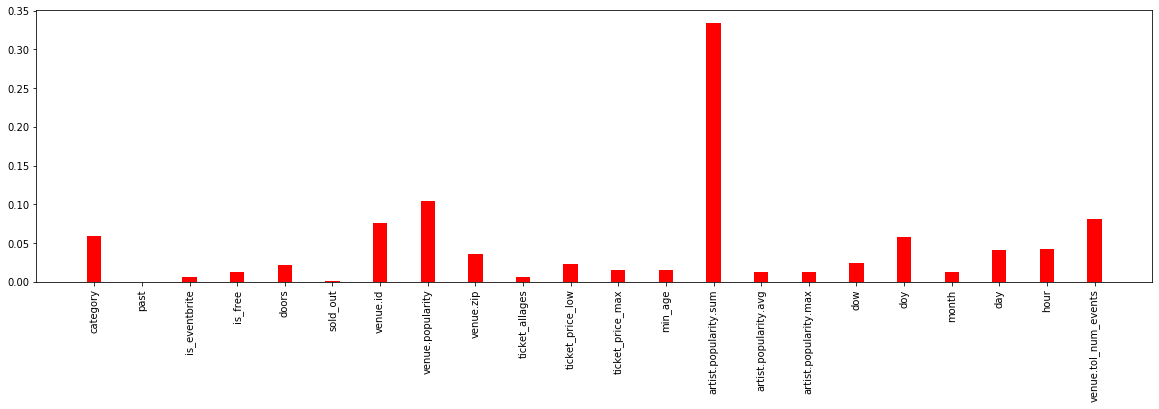

In [156]:
# Take a look at feature importance
f_importance = pd.DataFrame({'feature':udf_x.columns, 'importance':RF_model0.feature_importances_})
#plot histogram
lenc = len(udf.columns)-2
x_tick_label=[None]*lenc
hist_val=np.zeros(lenc)
for i in range(0,lenc):
    hist_val[i] = f_importance.values[i][1]
    x_tick_label[i] = f_importance.values[i][0]
    print(x_tick_label[i],hist_val[i])
    
index = np.arange(lenc)+1
fig, ax = plt.subplots(figsize=(20,5))
ax.bar(index,hist_val, .3, color='r')
ax.set_xticks(range(1, lenc+1, 1))
ax.set_xticklabels(x_tick_label, rotation='vertical')
plt.show()

In [167]:
# test the normalizing of features and redo model
udf_x.describe()

,category,past,is_eventbrite,is_free,doors,sold_out,venue.id,venue.popularity,venue.zip,ticket_allages,...,min_age,artist.popularity.sum,artist.popularity.avg,artist.popularity.max,dow,doy,month,day,hour,venue.tol_num_events
count,40703.000000,40703.000000,40703.000000,40703.000000,40703.000000,40703.000000,40703.000000,40703.000000,40703.000000,40703.000000,...,40703.000000,4.070300e+04,40703.000000,40703.000000,40703.000000,40703.000000,40703.000000,40703.000000,40703.000000,40703.000000
mean,4.399602,0.997789,0.044026,0.240572,0.106528,0.005675,171072.715328,3.214087,67319.659042,0.077021,...,2.806550,8.170296e+02,214.390463,214.390463,3.571137,167.768150,6.039948,15.442326,17.053927,189.294376
std,4.959572,0.046971,0.205156,0.427436,0.308516,0.075121,177810.695881,4.489557,27674.487779,0.266629,...,7.042276,3.408583e+04,3008.976730,3008.976730,1.809267,102.994374,3.356400,8.126201,4.285017,189.623127
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,697.000000,1.000000,78701.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,2.000000,73.000000,3.000000,9.000000,15.000000,27.000000
50%,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,35117.000000,1.000000,78701.000000,0.000000,...,0.000000,0.000000e+00,0.000000,0.000000,4.000000,151.000000,5.000000,15.000000,18.000000,117.000000
75%,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,372921.000000,2.000000,78705.000000,0.000000,...,0.000000,6.000000e+00,4.000000,4.000000,5.000000,262.000000,9.000000,22.000000,20.000000,311.000000
max,19.000000,1.000000,1.000000,1.000000,1.000000,1.000000,450640.000000,35.000000,90010.000000,1.000000,...,25.000000,4.478328e+06,137744.000000,137744.000000,6.000000,365.000000,12.000000,31.000000,23.000000,668.000000


In [ ]:
from sklearn import preprocessing
# make the scaler


In [157]:
# pickout the top few features and redo linear
for i in range(0,lenc-1):
    hist_val[i] = f_importance.values[i][1]
    x_tick_label[i] = f_importance.values[i][0]
    if hist_val[i]>0.03:
        print(x_tick_label[i],hist_val[i])

category 0.059192348991623046
venue.id 0.0764968934904855
venue.popularity 0.10494456615217765
venue.zip 0.03550129191073269
artist.popularity.sum 0.33398971669001914
doy 0.05847992618480576
day 0.041680737491322374
hour 0.04221765897589759


In [159]:
## try SGD
from sklearn.linear_model import SGDRegressor
SGD_model0 = SGDRegressor(random_state=12,verbose=10)

In [160]:
SGD_model0.fit(X_train,y_train)

-- Epoch 1
Norm: 418550719575624.81, NNZs: 22, Bias: 48755743890.982903, T: 28492, Avg. loss: 1789943311871947697540846156463854321664.000000
Total training time: 0.01 seconds.
-- Epoch 2
Norm: 367475307963820.44, NNZs: 22, Bias: 102801976790.957382, T: 56984, Avg. loss: 751297881082485078469340588226178449408.000000
Total training time: 0.01 seconds.
-- Epoch 3
Norm: 935021798469819.62, NNZs: 22, Bias: 176099321448.933838, T: 85476, Avg. loss: 559147065819205664939876725846670573568.000000
Total training time: 0.02 seconds.
-- Epoch 4
Norm: 1493745139979527.50, NNZs: 22, Bias: 261266478633.435974, T: 113968, Avg. loss: 468477234139591465634585263446333325312.000000
Total training time: 0.02 seconds.
-- Epoch 5
Norm: 384551793582291.44, NNZs: 22, Bias: 223003527204.569519, T: 142460, Avg. loss: 455591919461459234600661926766027210752.000000
Total training time: 0.02 seconds.
-- Epoch 6
Norm: 784629507368612.00, NNZs: 22, Bias: 188376170595.445557, T: 170952, Avg. loss: 3796038459565059

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=12,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=10,
             warm_start=False)

In [161]:
pred_train_SGD = SGD_model0.predict(X_train)
print('training score of RandomForest:',SGD_model0.score(X_train,pred_train_SGD))
pred_test_SGD = SGD_model0.predict(X_test)
print('test score of RandomForest:',SGD_model0.score(X_test,pred_test_SGD))

training score of RandomForest: 1.0
test score of RandomForest: 1.0


In [162]:
# access several benchmark RMSE for reference:
print('MSE score(training):',metrics.mean_squared_error(y_train, pred_train_SGD))
print('MAE score(training):',metrics.mean_absolute_error(y_train, pred_train_SGD))
print('MSE score:',metrics.mean_squared_error(y_test, pred_test_SGD))
print('MAE score:',metrics.mean_absolute_error(y_test, pred_test_SGD))

MSE score(training): 4.247626797072859e+38
MAE score(training): 1.566203539777999e+19
MSE score: 4.152630584396318e+38
MAE score: 1.5420814513887412e+19


#### plug in another unseen event to test prediction
{
    "_id" : ObjectId("5d8c9a30552e8c8c9c358d75"),
    "event_id" : "11129071",
    "title" : "cozymason",
    "venue" : {
        "address" : "801 Red River",
        "city" : "Austin",
        "state" : "TX",
        "zip" : "78701",
        "title" : "Stubb's",
        "location" : {
            "type" : "Point",
            "coordinates" : {
                "latitude" : 30.2684579,
                "longitude" : -97.7361748
            }
        }
    },
    "begin_time" : ISODate("2019-09-27T03:00:00.000Z"),
    "end_time" : ISODate("2019-09-27T07:00:00.000Z"),
    "category" : "Music ",
    "vote_count" : 5,
    "is_sold_out" : false,
    "source" : "Do512"
}

In [338]:
udf_x.columns

Index(['category', 'past', 'is_eventbrite', 'is_free', 'doors', 'sold_out',
       'venue.id', 'venue.popularity', 'venue.zip', 'ticket_allages',
       'ticket_price_low', 'ticket_price_max', 'min_age',
       'artist.popularity.sum', 'artist.popularity.avg',
       'artist.popularity.max', 'dow', 'doy', 'month', 'day', 'hour',
       'venue.tol_num_events'],
      dtype='object')

In [346]:
a=[0,1,0,1,1,0,113,15,78701,1,0,0,21,5,5,5,4,269,9,26,22,247]
test1in=pd.DataFrame(columns=udf_x.columns)
test1in.loc[len(test1in), :] = a


In [347]:
test1out=RF_model0.predict(test1in)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [348]:
test1out

array([28.])

In [190]:
udf['ticket_allages'].value_counts()

0    38708
1     3157
Name: ticket_allages, dtype: int64